In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from IPython.display import Video, display
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms
from typing import Any, List, Optional, Union

In [2]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
def pt_to_numpy(images: torch.FloatTensor) -> np.ndarray:
    return images.detach().cpu().permute(0, 2, 3, 1).float().numpy()


def numpy_to_pt(images: np.ndarray) -> torch.FloatTensor:
    if images.ndim == 3:
        images = images[..., None]
    return torch.from_numpy(images.transpose(0, 3, 1, 2))


def numpy_to_pil(images: np.ndarray) -> Image.Image:
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def pil_to_numpy(images: Union[List[Image.Image], Image.Image]) -> np.ndarray:
    if not isinstance(images, Image.Image) and not isinstance(images, list):
        raise ValueError(
            f"Expected PIL image or list of PIL images, got {type(images)}."
        )
    if not isinstance(images, list):
        images = [images]
    images = [np.array(image).astype(np.float32) / 255.0 for image in images]
    images = np.stack(images, axis=0)
    return images


def normalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return 2.0 * images - 1.0


def denormalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return (0.5 + images / 2).clamp(0, 1)


def pil_to_video(images: List[Image.Image], filename: str, fps: int = 60) -> None:
    frames = [np.array(image) for image in images]
    with imageio.get_writer(filename, fps=fps) as video_writer:
        for frame in frames:
            video_writer.append_data(frame)


def image_grid(images: List[Image.Image], rows: int, cols: int) -> Image.Image:
    if len(images) > rows * cols:
        raise ValueError(
            f"Number of images ({len(images)}) exceeds grid size ({rows}x{cols})."
        )
    w, h = images[0].size
    grid = Image.new("L", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
subset_size = 20000

In [5]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
    ),
    download=True,
)
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

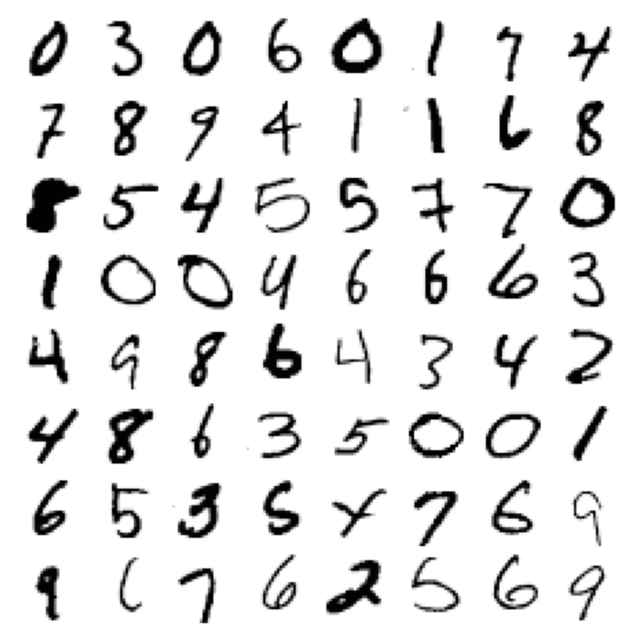

In [6]:
for batch_images, batch_labels in dataloader:
    rows = int(batch_size**0.5)
    if rows * rows < batch_size:
        rows += 1
    cols = rows
    batch_images = numpy_to_pil(pt_to_numpy(denormalize(batch_images)))
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image_grid(batch_images, rows=rows, cols=cols), cmap="Greys")
    plt.axis("off")
    plt.show()
    break

In [7]:
class Generator(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        latent_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        dropout: float = 0.4,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.device = device

        if len(hidden_dims) < 1:
            raise ValueError(
                f"hidden_dims should have length of atleast 1, but got {len(hidden_dims)}"
            )

        def block(in_dim: int, out_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim), nn.ReLU(inplace=True), nn.Dropout(dropout)
            )

        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, embedding_dim=embedding_dim
        )
        self.model = nn.Sequential()

        self.model.append(block(latent_dim + embedding_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.model.append(block(hidden_dims[i - 1], hidden_dims[i]))
        self.model.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model.append(nn.Tanh())

    def forward(
        self, latent: torch.FloatTensor, labels: torch.LongTensor
    ) -> torch.FloatTensor:
        latent = latent.to(self.device)
        labels = labels.to(self.device)

        latent = latent.view(-1, self.latent_dim)
        embedding = self.embedding(labels).view(-1, self.embedding_dim)
        x = torch.cat([latent, embedding], dim=1)
        x = self.model(x)

        return x.view(-1, 28, 28)

In [8]:
class Discriminator(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        dropout: float = 0.4,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.device = device

        if len(hidden_dims) < 1:
            raise ValueError(
                f"hidden_dims should have length of atleast 1, but got {len(hidden_dims)}"
            )

        def block(in_dim: int, out_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(dropout),
            )

        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, embedding_dim=embedding_dim
        )
        self.model = nn.Sequential()

        self.model.append(block(input_dim + embedding_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.model.append(block(hidden_dims[i - 1], hidden_dims[i]))
        self.model.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model.append(nn.Sigmoid())

        self.to(device)

    def forward(
        self, images: torch.FloatTensor, labels: torch.LongTensor
    ) -> torch.FloatTensor:
        images = images.to(self.device)
        labels = labels.to(self.device)

        images = images.view(-1, 28 * 28)
        embedding = self.embedding(labels).view(-1, self.embedding_dim)
        x = torch.cat([images, embedding], dim=1)
        x = self.model(x)

        return x.squeeze()

In [9]:
epochs = 40
learning_rate_g = 2e-4
learning_rate_d = 5e-4
latent_dim = 160
num_embeddings = 10  # 10 classes in MNIST
embedding_dim = 10
dropout = 0.4
log_steps = 100

generator_hidden_dims = [256, 512, 1024]
discriminator_hidden_dims = [1024, 512, 256]

In [10]:
generator = Generator(
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    output_dim=28 * 28,
    hidden_dims=generator_hidden_dims,
    dropout=dropout,
    device=device,
)
discriminator = Discriminator(
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    input_dim=28 * 28,
    output_dim=1,
    hidden_dims=discriminator_hidden_dims,
    dropout=dropout,
    device=device,
)

In [11]:
_ = summary(
    generator,
    [
        (
            1,
            latent_dim,
        ),
        (1,),
    ],
    dtypes=[torch.FloatTensor, torch.LongTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 1, 10]               100
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Sequential: 2-1                   [-1, 256]                 --
|    |    └─Linear: 3-1                  [-1, 256]                 43,776
|    |    └─ReLU: 3-2                    [-1, 256]                 --
|    |    └─Dropout: 3-3                 [-1, 256]                 --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-4                  [-1, 512]                 131,584
|    |    └─ReLU: 3-5                    [-1, 512]                 --
|    |    └─Dropout: 3-6                 [-1, 512]                 --
|    └─Sequential: 2-3                   [-1, 1024]                --
|    |    └─Linear: 3-7                  [-1, 1024]                525,312
|    |    └─ReLU: 3-8                    [-1, 1024]                --


In [12]:
_ = summary(
    discriminator,
    [(1, 28, 28), (1,)],
    dtypes=[torch.FloatTensor, torch.LongTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 1, 10]               100
├─Sequential: 1-2                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 1024]                --
|    |    └─Linear: 3-1                  [-1, 1024]                814,080
|    |    └─LeakyReLU: 3-2               [-1, 1024]                --
|    |    └─Dropout: 3-3                 [-1, 1024]                --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-4                  [-1, 512]                 524,800
|    |    └─LeakyReLU: 3-5               [-1, 512]                 --
|    |    └─Dropout: 3-6                 [-1, 512]                 --
|    └─Sequential: 2-3                   [-1, 256]                 --
|    |    └─Linear: 3-7                  [-1, 256]                 131,328
|    |    └─LeakyReLU: 3-8               [-1, 256]                 --

In [13]:
loss = nn.BCELoss()
optim_g = torch.optim.AdamW(generator.parameters(), lr=learning_rate_g)
optim_d = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate_d)

In [14]:
def trainstep_g():
    optim_g.zero_grad()

    latent = torch.randn((batch_size, latent_dim))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = generator(latent, fake_labels)

    validity = discriminator(fake_images, fake_labels)
    fake_loss = loss(validity, torch.ones(batch_size, device=device))

    fake_loss.backward()
    optim_g.step()

    return fake_loss

In [15]:
def trainstep_d(images, labels):
    optim_d.zero_grad()

    # We can't use the global batch_size because dataloader may have truncation
    # for last uncomplete batch
    batch_size = images.shape[0]

    real_validity = discriminator(images, labels)
    real_loss = loss(real_validity, torch.ones(batch_size, device=device))

    latent = torch.randn((batch_size, latent_dim))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = generator(latent, fake_labels)

    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = loss(fake_validity, torch.zeros(batch_size, device=device))

    discriminator_loss = (real_loss + fake_loss) / 2

    discriminator_loss.backward()
    optim_d.step()

    return discriminator_loss

In [16]:
grid_images = []
generator_losses = []
discriminator_losses = []

In [17]:
def train(epochs: int):
    steps = 0
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        generator.train()

        for index, (images, labels) in enumerate(dataloader):
            generator_loss = trainstep_g().mean().item()
            discriminator_loss = trainstep_d(images, labels).mean().item()
            generator_losses.append(generator_loss)
            discriminator_losses.append(discriminator_loss)

            if steps % log_steps == 0:
                print(
                    f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
                )
            steps += 1

        print(
            f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
        )
        print("-" * 64)

        grid_image = visualize(64)
        grid_images.append(grid_image)

        if epoch % 4 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(grid_image, cmap="Greys")
            plt.axis("off")
            plt.show()


def visualize(sample_size: int):
    # Ensure that the same random labels are generated each time
    gen = torch.Generator(device="cpu").manual_seed(42)
    labels = torch.randint(0, num_embeddings, (sample_size,), generator=gen)

    with torch.no_grad():
        generator.eval()

        latents = torch.randn((sample_size, latent_dim))
        sampled_images = generator(latents, labels).unsqueeze(dim=1)

        rows = int(sample_size**0.5)
        cols = rows

        if rows * rows < sample_size:
            rows += 1

        sampled_images = numpy_to_pil(pt_to_numpy(denormalize(sampled_images)))
        grid_image = image_grid(sampled_images, rows=rows, cols=cols)

    return grid_image

Epoch: 0, Generator loss: 0.7234, Discriminator loss: 0.7117
Epoch: 0, Generator loss: 5.7520, Discriminator loss: 0.0181
Epoch: 0, Generator loss: 2.2126, Discriminator loss: 0.3183
Epoch: 0, Generator loss: 9.1304, Discriminator loss: 0.1112
Epoch: 0, Generator loss: 16.4696, Discriminator loss: 0.0271
----------------------------------------------------------------


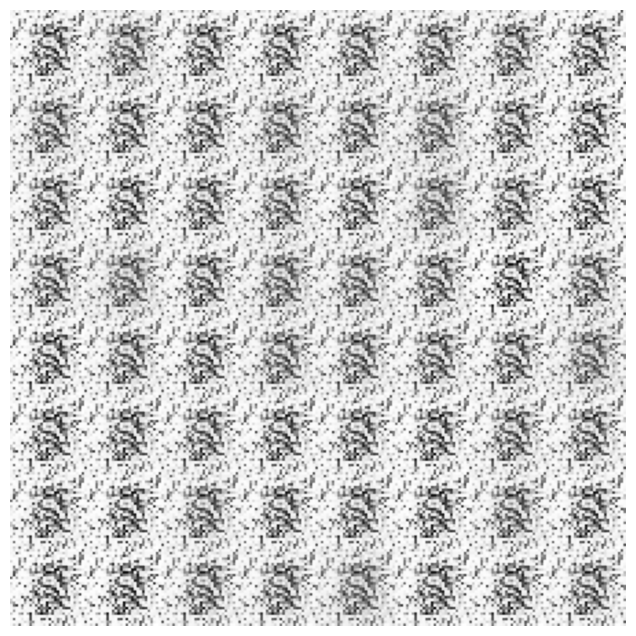

Epoch: 1, Generator loss: 1.4194, Discriminator loss: 0.5085
Epoch: 1, Generator loss: 5.3640, Discriminator loss: 0.0829
Epoch: 1, Generator loss: 4.5042, Discriminator loss: 0.1365
Epoch: 1, Generator loss: 2.3703, Discriminator loss: 0.3192
----------------------------------------------------------------
Epoch: 2, Generator loss: 7.6986, Discriminator loss: 0.0219
Epoch: 2, Generator loss: 1.5752, Discriminator loss: 0.4569
Epoch: 2, Generator loss: 11.0883, Discriminator loss: 0.1804
Epoch: 2, Generator loss: 6.8465, Discriminator loss: 0.4570
----------------------------------------------------------------
Epoch: 3, Generator loss: 8.1583, Discriminator loss: 0.4689
Epoch: 3, Generator loss: 17.2676, Discriminator loss: 0.0445
Epoch: 3, Generator loss: 2.0542, Discriminator loss: 0.1902
Epoch: 3, Generator loss: 3.1553, Discriminator loss: 0.2836
----------------------------------------------------------------
Epoch: 4, Generator loss: 1.6645, Discriminator loss: 0.4761
Epoch: 4, 

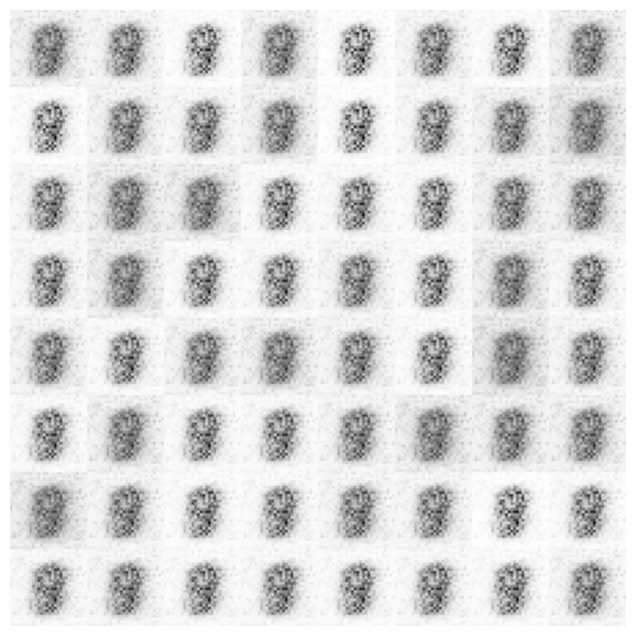

Epoch: 5, Generator loss: 9.2197, Discriminator loss: 0.2028
Epoch: 5, Generator loss: 5.3959, Discriminator loss: 0.0939
Epoch: 5, Generator loss: 5.3632, Discriminator loss: 0.1480
Epoch: 5, Generator loss: 7.4724, Discriminator loss: 0.1352
----------------------------------------------------------------
Epoch: 6, Generator loss: 6.0678, Discriminator loss: 0.0595
Epoch: 6, Generator loss: 7.0016, Discriminator loss: 0.1510
Epoch: 6, Generator loss: 4.9675, Discriminator loss: 0.1935
Epoch: 6, Generator loss: 6.5278, Discriminator loss: 0.0752
----------------------------------------------------------------
Epoch: 7, Generator loss: 6.8196, Discriminator loss: 0.0784
Epoch: 7, Generator loss: 6.3770, Discriminator loss: 0.1955
Epoch: 7, Generator loss: 7.1455, Discriminator loss: 0.1914
Epoch: 7, Generator loss: 5.5823, Discriminator loss: 0.0591
Epoch: 7, Generator loss: 8.3563, Discriminator loss: 0.1461
----------------------------------------------------------------
Epoch: 8, Ge

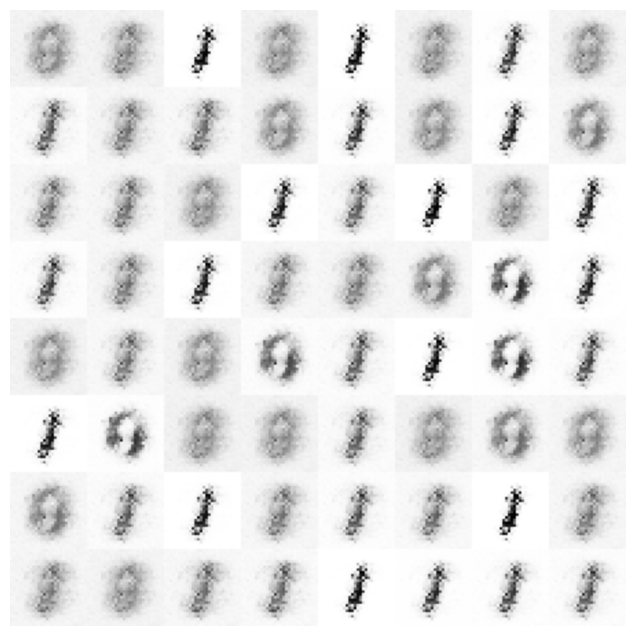

Epoch: 9, Generator loss: 5.2267, Discriminator loss: 0.1004
Epoch: 9, Generator loss: 3.8138, Discriminator loss: 0.2490
Epoch: 9, Generator loss: 6.4196, Discriminator loss: 0.0812
Epoch: 9, Generator loss: 3.1179, Discriminator loss: 0.2339
----------------------------------------------------------------
Epoch: 10, Generator loss: 5.5287, Discriminator loss: 0.1971
Epoch: 10, Generator loss: 4.6603, Discriminator loss: 0.0960
Epoch: 10, Generator loss: 3.2073, Discriminator loss: 0.1004
Epoch: 10, Generator loss: 4.3621, Discriminator loss: 0.0694
----------------------------------------------------------------
Epoch: 11, Generator loss: 6.1940, Discriminator loss: 0.1026
Epoch: 11, Generator loss: 5.0129, Discriminator loss: 0.1394
Epoch: 11, Generator loss: 3.2831, Discriminator loss: 0.2039
Epoch: 11, Generator loss: 3.4425, Discriminator loss: 0.2756
----------------------------------------------------------------
Epoch: 12, Generator loss: 6.2793, Discriminator loss: 0.1954
Epo

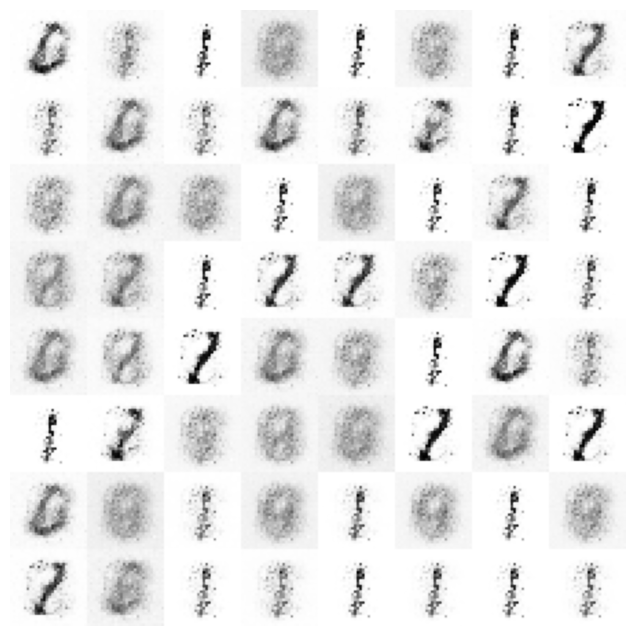

Epoch: 13, Generator loss: 4.9313, Discriminator loss: 0.1303
Epoch: 13, Generator loss: 4.0628, Discriminator loss: 0.1800
Epoch: 13, Generator loss: 3.7577, Discriminator loss: 0.0724
Epoch: 13, Generator loss: 7.1751, Discriminator loss: 0.0763
----------------------------------------------------------------
Epoch: 14, Generator loss: 5.7945, Discriminator loss: 0.2199
Epoch: 14, Generator loss: 5.5401, Discriminator loss: 0.1450
Epoch: 14, Generator loss: 4.0039, Discriminator loss: 0.1542
Epoch: 14, Generator loss: 6.2939, Discriminator loss: 0.0360
----------------------------------------------------------------
Epoch: 15, Generator loss: 5.9202, Discriminator loss: 0.1131
Epoch: 15, Generator loss: 4.1755, Discriminator loss: 0.2271
Epoch: 15, Generator loss: 5.0651, Discriminator loss: 0.1259
Epoch: 15, Generator loss: 5.8468, Discriminator loss: 0.1619
Epoch: 15, Generator loss: 6.7170, Discriminator loss: 0.1147
----------------------------------------------------------------

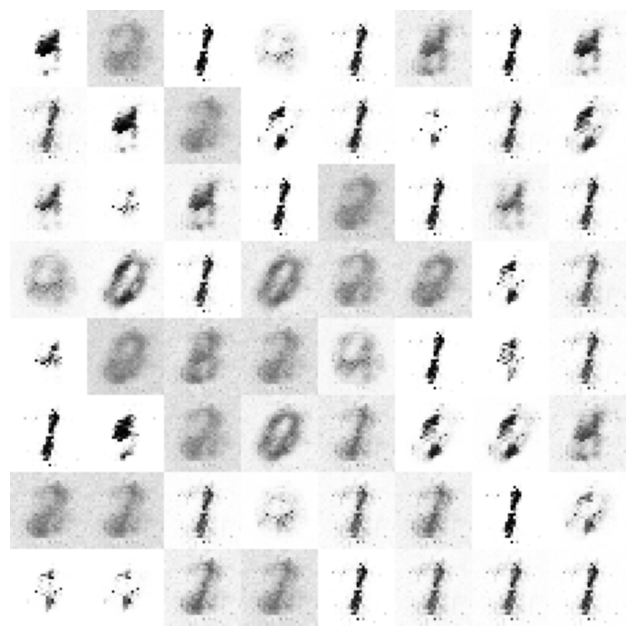

Epoch: 17, Generator loss: 4.3137, Discriminator loss: 0.1473
Epoch: 17, Generator loss: 4.4810, Discriminator loss: 0.1418
Epoch: 17, Generator loss: 3.8602, Discriminator loss: 0.1838
Epoch: 17, Generator loss: 4.6363, Discriminator loss: 0.0747
----------------------------------------------------------------
Epoch: 18, Generator loss: 3.7054, Discriminator loss: 0.1260
Epoch: 18, Generator loss: 2.8806, Discriminator loss: 0.2218
Epoch: 18, Generator loss: 3.3326, Discriminator loss: 0.1021
Epoch: 18, Generator loss: 6.4172, Discriminator loss: 0.1419
----------------------------------------------------------------
Epoch: 19, Generator loss: 2.3074, Discriminator loss: 0.2300
Epoch: 19, Generator loss: 3.5727, Discriminator loss: 0.1890
Epoch: 19, Generator loss: 2.3771, Discriminator loss: 0.2190
Epoch: 19, Generator loss: 3.7034, Discriminator loss: 0.1223
----------------------------------------------------------------
Epoch: 20, Generator loss: 3.1762, Discriminator loss: 0.2747

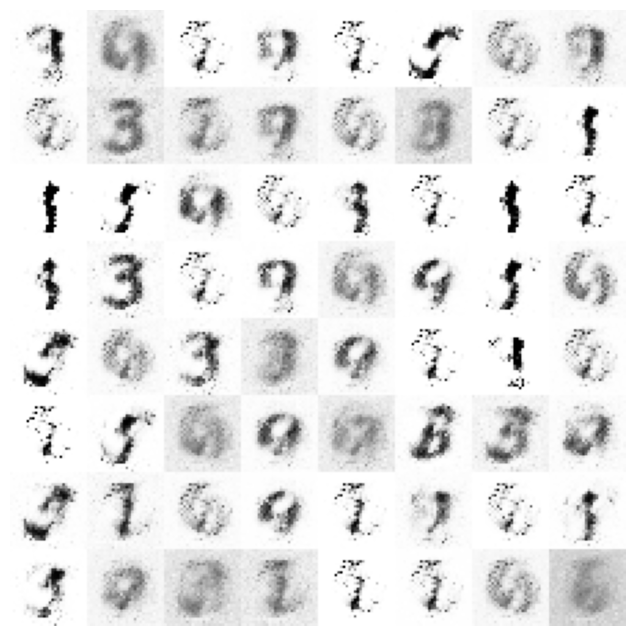

Epoch: 21, Generator loss: 4.5865, Discriminator loss: 0.2730
Epoch: 21, Generator loss: 5.3296, Discriminator loss: 0.1167
Epoch: 21, Generator loss: 3.4736, Discriminator loss: 0.2366
Epoch: 21, Generator loss: 6.6446, Discriminator loss: 0.0526
----------------------------------------------------------------
Epoch: 22, Generator loss: 6.1827, Discriminator loss: 0.3252
Epoch: 22, Generator loss: 4.3044, Discriminator loss: 0.2579
Epoch: 22, Generator loss: 4.2631, Discriminator loss: 0.2495
Epoch: 22, Generator loss: 5.2043, Discriminator loss: 0.2636
----------------------------------------------------------------
Epoch: 23, Generator loss: 3.1953, Discriminator loss: 0.1680
Epoch: 23, Generator loss: 4.6568, Discriminator loss: 0.1517
Epoch: 23, Generator loss: 3.8307, Discriminator loss: 0.1276
Epoch: 23, Generator loss: 4.6050, Discriminator loss: 0.2752
Epoch: 23, Generator loss: 3.4448, Discriminator loss: 0.1352
----------------------------------------------------------------

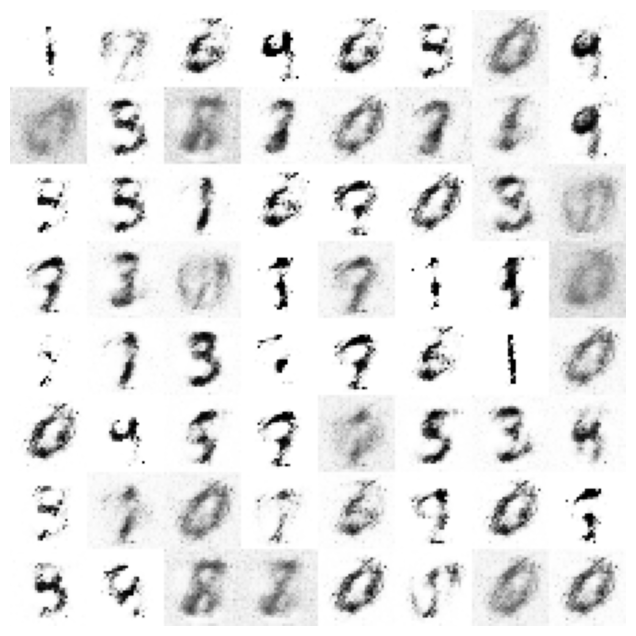

Epoch: 25, Generator loss: 3.9936, Discriminator loss: 0.2331
Epoch: 25, Generator loss: 4.3427, Discriminator loss: 0.1063
Epoch: 25, Generator loss: 3.4247, Discriminator loss: 0.1877
Epoch: 25, Generator loss: 3.5076, Discriminator loss: 0.1632
----------------------------------------------------------------
Epoch: 26, Generator loss: 3.0529, Discriminator loss: 0.3189
Epoch: 26, Generator loss: 2.9526, Discriminator loss: 0.2232
Epoch: 26, Generator loss: 5.6105, Discriminator loss: 0.2060
Epoch: 26, Generator loss: 6.4065, Discriminator loss: 0.2030
----------------------------------------------------------------
Epoch: 27, Generator loss: 4.8153, Discriminator loss: 0.3026
Epoch: 27, Generator loss: 5.0962, Discriminator loss: 0.2229
Epoch: 27, Generator loss: 5.0159, Discriminator loss: 0.1361
Epoch: 27, Generator loss: 2.9970, Discriminator loss: 0.2607
----------------------------------------------------------------
Epoch: 28, Generator loss: 4.4750, Discriminator loss: 0.3340

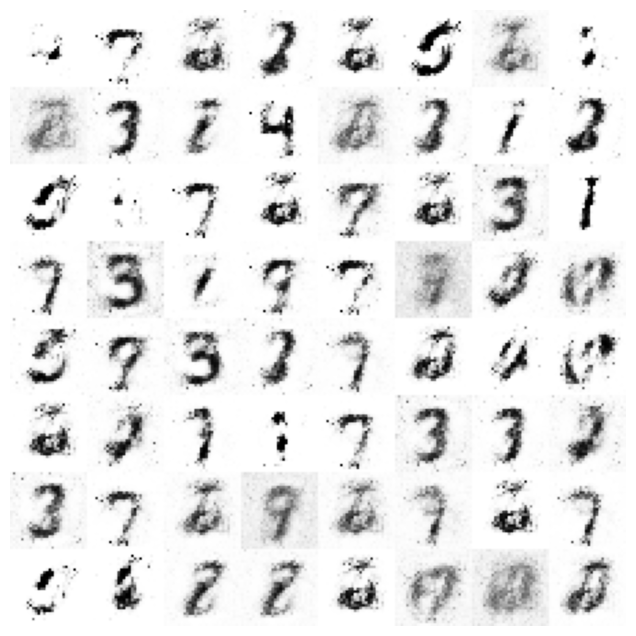

Epoch: 29, Generator loss: 2.3069, Discriminator loss: 0.2689
Epoch: 29, Generator loss: 3.6444, Discriminator loss: 0.3175
Epoch: 29, Generator loss: 1.5410, Discriminator loss: 0.3246
Epoch: 29, Generator loss: 2.2528, Discriminator loss: 0.2086
----------------------------------------------------------------
Epoch: 30, Generator loss: 2.5628, Discriminator loss: 0.3082
Epoch: 30, Generator loss: 2.2514, Discriminator loss: 0.2654
Epoch: 30, Generator loss: 3.5287, Discriminator loss: 0.2302
Epoch: 30, Generator loss: 4.1803, Discriminator loss: 0.3517
Epoch: 30, Generator loss: 3.1862, Discriminator loss: 0.3308
----------------------------------------------------------------
Epoch: 31, Generator loss: 3.3054, Discriminator loss: 0.3626
Epoch: 31, Generator loss: 2.5915, Discriminator loss: 0.3771
Epoch: 31, Generator loss: 5.3878, Discriminator loss: 0.1704
Epoch: 31, Generator loss: 5.8461, Discriminator loss: 0.2808
----------------------------------------------------------------

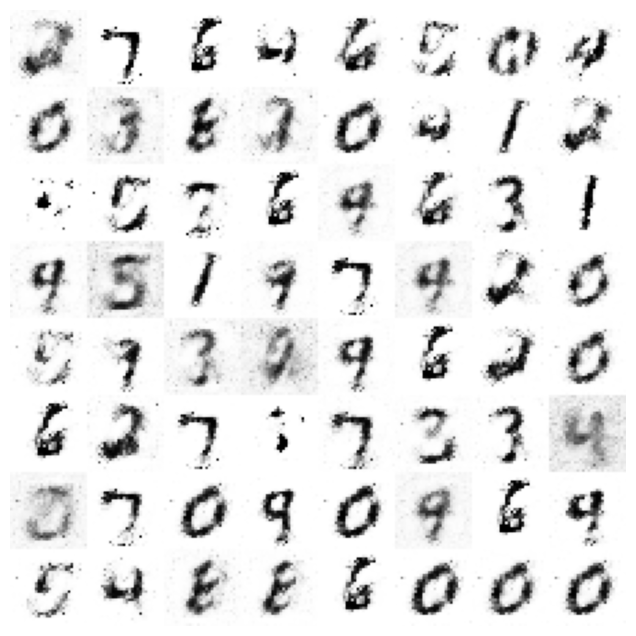

Epoch: 33, Generator loss: 4.8459, Discriminator loss: 0.2618
Epoch: 33, Generator loss: 5.1486, Discriminator loss: 0.2337
Epoch: 33, Generator loss: 2.2325, Discriminator loss: 0.2194
Epoch: 33, Generator loss: 3.6196, Discriminator loss: 0.2837
----------------------------------------------------------------
Epoch: 34, Generator loss: 2.9212, Discriminator loss: 0.3265
Epoch: 34, Generator loss: 2.5537, Discriminator loss: 0.2925
Epoch: 34, Generator loss: 2.5948, Discriminator loss: 0.3488
Epoch: 34, Generator loss: 2.8316, Discriminator loss: 0.2927
----------------------------------------------------------------
Epoch: 35, Generator loss: 2.4209, Discriminator loss: 0.4211
Epoch: 35, Generator loss: 3.7950, Discriminator loss: 0.2249
Epoch: 35, Generator loss: 2.7502, Discriminator loss: 0.2925
Epoch: 35, Generator loss: 2.5390, Discriminator loss: 0.3315
----------------------------------------------------------------
Epoch: 36, Generator loss: 4.6710, Discriminator loss: 0.1821

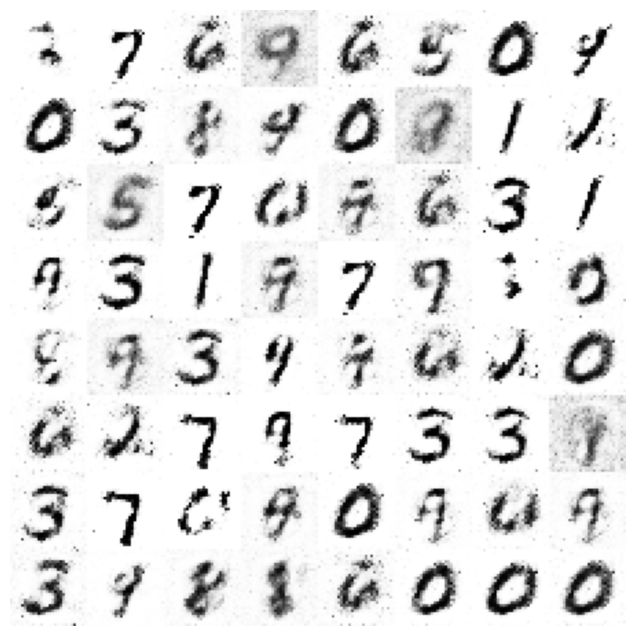

Epoch: 37, Generator loss: 4.3696, Discriminator loss: 0.3030
Epoch: 37, Generator loss: 2.2629, Discriminator loss: 0.2628
Epoch: 37, Generator loss: 4.3530, Discriminator loss: 0.2452
Epoch: 37, Generator loss: 5.0867, Discriminator loss: 0.2718
----------------------------------------------------------------
Epoch: 38, Generator loss: 4.8906, Discriminator loss: 0.3576
Epoch: 38, Generator loss: 4.4360, Discriminator loss: 0.3804
Epoch: 38, Generator loss: 2.1415, Discriminator loss: 0.3122
Epoch: 38, Generator loss: 2.4478, Discriminator loss: 0.3357
Epoch: 38, Generator loss: 1.8361, Discriminator loss: 0.3156
----------------------------------------------------------------
Epoch: 39, Generator loss: 1.7862, Discriminator loss: 0.2465
Epoch: 39, Generator loss: 1.2738, Discriminator loss: 0.3701
Epoch: 39, Generator loss: 1.6150, Discriminator loss: 0.4419
Epoch: 39, Generator loss: 2.8082, Discriminator loss: 0.3996
----------------------------------------------------------------

In [18]:
train(epochs)

In [19]:
filename = "generation_over_time.mp4"
pil_to_video(grid_images, filename, fps=8)

In [20]:
display(Video(filename, embed=True))

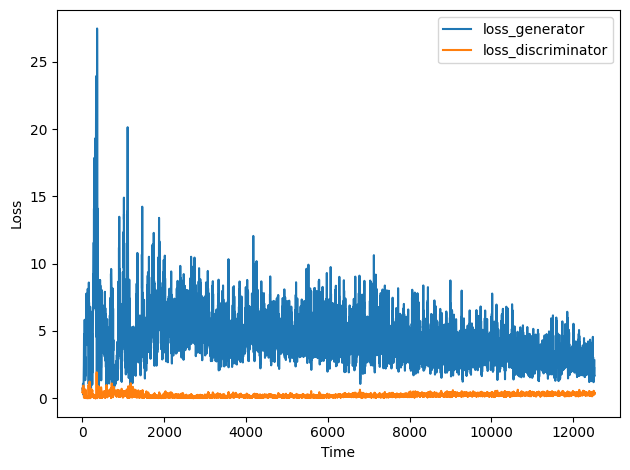

In [21]:
plt.plot(generator_losses, label="loss_generator")
plt.plot(discriminator_losses, label="loss_discriminator")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend()
plt.show()

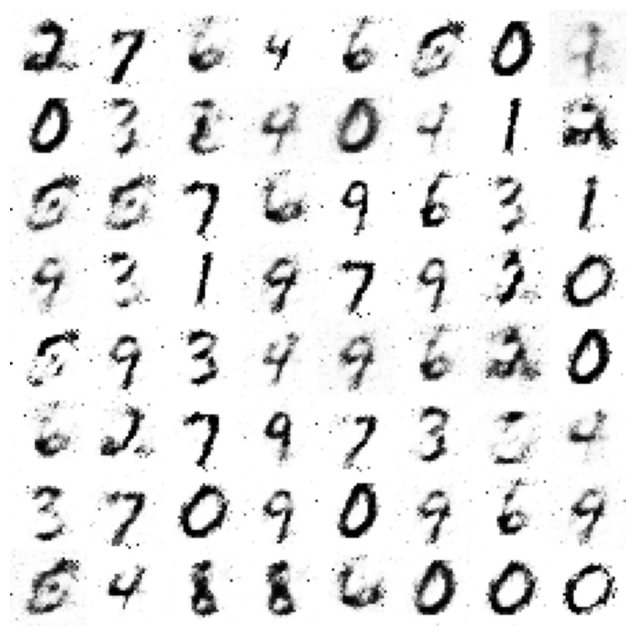

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(visualize(64), cmap="Greys")
plt.axis("off")
plt.show()